In [48]:
from tyssue import PlanarGeometry, Sheet, History
from tyssue.dynamics import effectors, model_factory
from tyssue.geometry.base_geometry import update_periodic_dcoords  # Use the full path


import os
import ipyvolume as ipv
import tyssue
import json
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
import sys
import logging
import tyssue.io.hdf5 as hdf5
from IPython.display import Image
from scipy import optimize
from tyssue.draw import sheet_view

from tyssue import Sheet
from tyssue import SheetGeometry

##### Own functions
import src.cellDivisionOld as cellDivisionOld
import src.cellDivision as cellDivision
import src.vertexModel as vertexModel
import src.inputMechanicalParameters as inputMechanicalParameters
import src.auxFunctions as auxFunctions
from tyssue.topology import add_vert

from tyssue.draw.plt_draw import create_gif
from tyssue.draw import highlight_faces, create_gif
from IPython.display import Image

from tyssue.topology.base_topology import add_vert, close_face, collapse_edge, remove_face
from tyssue.topology.base_topology import split_vert as base_split_vert

from matplotlib import cm
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from math import sqrt
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
import json

import pickle 
import gzip

import imageio

import logging
logger = logging.getLogger(name=__name__)

import warnings
warnings.filterwarnings("ignore")


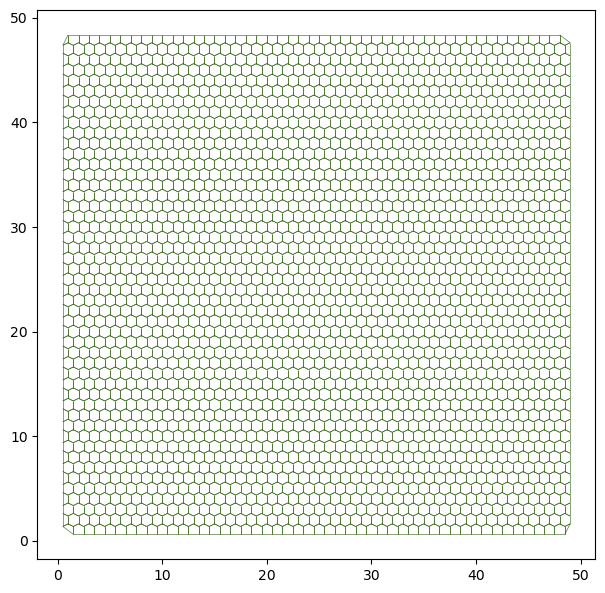

In [46]:
# Step 1: Define the parameters for the sheet
n_cells_x = 50  # Number of cells along the x-axis
n_cells_y = 50 # Number of cells along the y-axis
L_x = 50.0     # Length along the x-axis
L_y = 50.0     # Length along the y-axis

# Step 2: Create the planar sheet
sheet = Sheet.planar_sheet_2d(
    'basic2D',
    nx=n_cells_x,  # Set the number of columns (cells along x)
    ny=n_cells_y,  # Set the number of rows (cells along y)
    distx=L_x/n_cells_x,  # Distance between cells along x
    disty=L_y/n_cells_y   # Distance between cells along y
)

# Step 3: Update the geometry for the sheet
geom = PlanarGeometry # Initialize a Geometry object
geom.update_all(sheet)

# Sanitize the sheet to prepare it for simulation
sheet.sanitize(trim_borders=True, order_edges=True)
geom.update_all(sheet)


fig, ax = sheet_view(sheet)
fig.set_size_inches(8, 8)



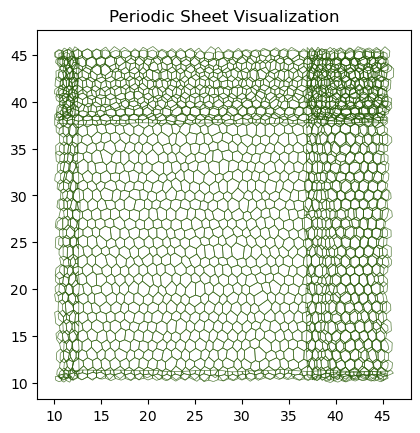

In [49]:
# Step 4: Define energy contributions
energyContributions_model = model_factory([
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity,
])

# Update the specifications for energy contributions
sheet.update_specs(energyContributions_model.specs)

# Set periodic boundary conditions
sheet.update_specs({
    "settings": {
        "boundaries": {
            "x": [10, 45],
            "y": [10, 45]
        }
    }
})

# Add viscosity specification for vertices
sheet.update_specs({
    "vert": {
        "viscosity": 1384  # Example viscosity value; adjust as necessary
    }
})

# Define the length elasticity range
rangeLengthElasticity = True  # Set this to True to enable the range logic

if rangeLengthElasticity:
    lower_FRC_le = 25
    higher_FRC_le = 40
    lower_ECM_le = 32
    higher_ECM_le = 433
    
    # Apply the length elasticity range using a helper function
    # Assuming auxFunctions.length_elasticity_range modifies the edge_df correctly
    cellmap = auxFunctions.length_elasticity_range(sheet, lower_FRC_le, higher_FRC_le,
                                                   lower_ECM_le, higher_ECM_le)
else:
    # Set a default length elasticity for all edges if the range is not used
    sheet.edge_df["length_elasticity"] = 200.0

# Update edge specifications with the calculated length elasticity
sheet.update_specs(
    {"edge": {"length_elasticity": sheet.edge_df["length_elasticity"].values}},
    reset=True
)

# Other specifications
sheet.update_specs(
    {"edge": {"prefered_length": 0.1}},
    reset=True
)

sheet.update_specs(
    {"face": {"prefered_area": 10}},
    reset=True
)

sheet.update_specs(
    {"face": {"area_elasticity": 10}},
    reset=True
)

sheet.update_specs(
    {"vert": {"viscosity": 1384}},
    reset=True
)


update_periodic_dcoords(sheet)


# Step 6: Run the simulation
[sheet, geom, model, history, solver] = vertexModel.solveEuler(sheet, geom, energyContributions_model, endTime=100)

# Visualize the periodic sheet
fig, ax = sheet_view(sheet)
plt.title('Periodic Sheet Visualization')
plt.show()


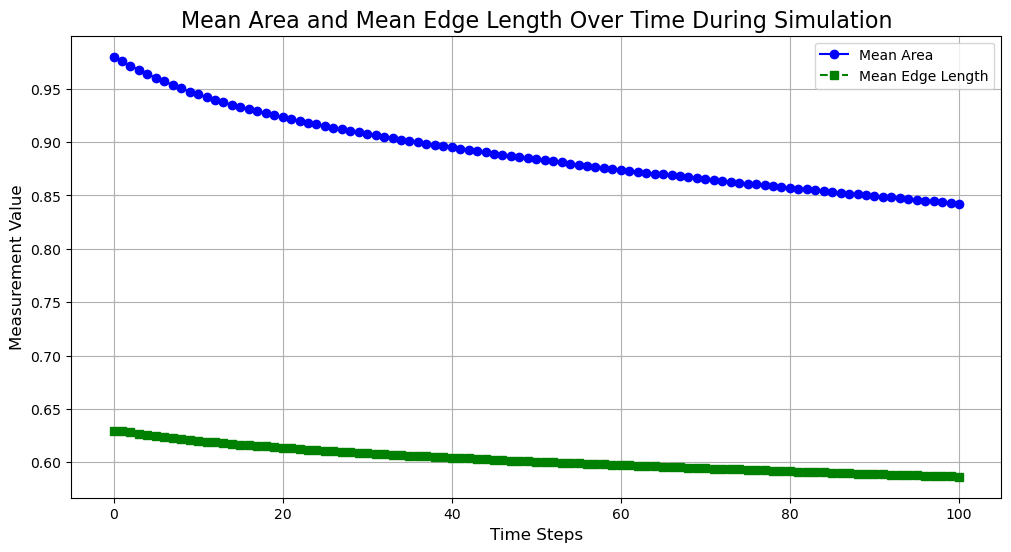

In [50]:
mean_areas = []
mean_edge_lengths = []

# After each time step, record the mean area and mean edge length
for t, cellmap in solver.history:
    mean_area = cellmap.face_df['area'].mean()
    mean_edge_length = cellmap.edge_df['length'].mean()
    mean_areas.append(mean_area)
    mean_edge_lengths.append(mean_edge_length)

# Plotting the mean area and mean edge length over time to check if they stabilize
time_steps = range(len(mean_areas))
plt.figure(figsize=(12, 6))

# Plot Mean Area
plt.plot(time_steps, mean_areas, marker='o', linestyle='-', color='blue', label='Mean Area')

# Plot Mean Edge Length
plt.plot(time_steps, mean_edge_lengths, marker='s', linestyle='--', color='green', label='Mean Edge Length')

# Customize the plot
plt.title('Mean Area and Mean Edge Length Over Time During Simulation', fontsize=16)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Measurement Value', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()

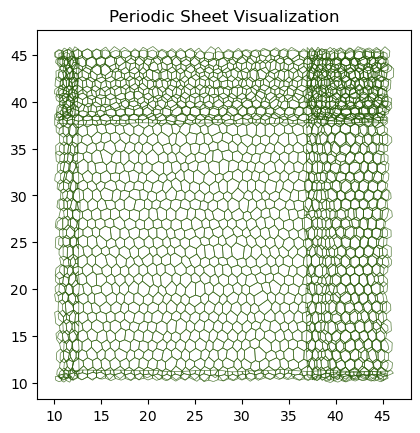

In [51]:
# Visualize the periodic sheet
fig, ax = sheet_view(sheet)
plt.title('Periodic Sheet Visualization')
plt.show()


In [54]:
def view_with_highlights(cellmap, geom, highlight_vertex=None, highlight_edges=None):
    """
    Visualizes the cellmap with options to show and highlight specific vertices.
    Includes edge highlighting and optional vertex highlighting.
    
    Parameters:
    - cellmap: The cell map containing the geometry.
    - geom: Geometry object to update and use for visualization.
    - highlight_vertex: List of vertex indices to highlight (optional). Default is None.
    """
    # Update the geometry
    geom.update_all(cellmap)

    # Set default edge color and width
    cellmap.edge_df["color_edges"] = -1  # Default blue color for non-highlighted edges
    cellmap.edge_df['edge_width'] = 1  # Default edge width

    # Ensure each vertex has its own color and size setting
    cellmap.vert_df['color_verts'] = 'blue'  # Default color for all vertices
    cellmap.vert_df['vert_size'] = 3         # Default size for all vertices

    # Apply specific color and size for highlighted vertices if provided
    if highlight_vertex:
        cellmap.vert_df.loc[highlight_vertex, 'color_verts'] = 'red'  # Highlight color
        cellmap.vert_df.loc[highlight_vertex, 'vert_size'] = 30        # Larger size for highlighted vertices
        
    if highlight_edges:
        cellmap.edge_df.loc[highlight_edges, 'color_edges'] = 1  # Highlight color
        cellmap.edge_df.loc[highlight_edges, 'edge_width'] = 3      # Larger size for highlighted vertices
        

    # Create the plot with edge and vertex highlighting
    fig, ax = sheet_view(
        cellmap,
        mode="2D",
        face={"visible": False},
        edge={
            "visible": True,
            "head_width": 0.0,
            "color": cellmap.edge_df['color_edges'],  # Dynamic edge colors
            "colormap": "bwr",
            "width": cellmap.edge_df['edge_width'],
            "alpha": 1.0
        },
        vert={
            "visible": True,
            "color": cellmap.vert_df['color_verts'],  # Vertex-specific colors
            "s": cellmap.vert_df['vert_size'],        # Vertex-specific sizes
            "alpha": 1.0
        }
    )
    fig.set_size_inches(15, 15)
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax


In [57]:
def collapse_chosen_edge_and_save_frames(sheet, geom, energyContributions_model, chosen_edge, frame_count, gif_folder):
    """
    Merges the two vertices connected by a chosen edge into a single new vertex,
    reconnects the edges to this new vertex, and saves frames before and after each step.
    Also solves for energy after each merge.

    Parameters:
    - sheet: The current cellmap sheet
    - geom: The geometry object
    - energyContributions_model: The energy model
    - chosen_edge: ID of the edge to collapse
    - frame_count: Current frame count (used for naming)
    - gif_folder: Folder to save frames as PNG
    """
    logger.info(f"Chosen edge: {chosen_edge}")

    # Identify the vertices connected by the chosen edge
    edge = sheet.edge_df.loc[chosen_edge]
    srce_vertex = edge['srce']
    trgt_vertex = edge['trgt']
    
    opposites = sheet.edge_df[(sheet.edge_df["srce"] == trgt_vertex) & (sheet.edge_df["trgt"] == srce_vertex)]


    logger.info(f"Vertices to be merged: {srce_vertex}, {trgt_vertex}")

    # Find all edges connected to srce_vertex and trgt_vertex
    connected_edges_srce = sheet.edge_df[
        (sheet.edge_df["srce"] == srce_vertex) | (sheet.edge_df["trgt"] == srce_vertex)
    ]
    connected_edges_trgt = sheet.edge_df[
        (sheet.edge_df["srce"] == trgt_vertex) | (sheet.edge_df["trgt"] == trgt_vertex)
    ]
    print(f"Number of edges connected to srce_vertex ({srce_vertex}): {len(connected_edges_srce)}")
    print(f"Number of edges connected to trgt_vertex ({trgt_vertex}): {len(connected_edges_trgt)}")

    # Step 1: Merge the two vertices by redirecting the edges
    new_vertex_id = max(sheet.vert_df.index) + 1

    # Average x, y coordinates for the new vertex
    new_vertex_data = {
        'x': (sheet.vert_df.loc[srce_vertex, 'x'] + sheet.vert_df.loc[trgt_vertex, 'x']) / 2,
        'y': (sheet.vert_df.loc[srce_vertex, 'y'] + sheet.vert_df.loc[trgt_vertex, 'y']) / 2,
        'viscosity': (sheet.vert_df.loc[srce_vertex, 'viscosity'] + sheet.vert_df.loc[trgt_vertex, 'viscosity']) / 2,
        'is_active': 1.0  # Assuming the new vertex is active
    }

    # Add the new vertex to vert_df
    sheet.vert_df.loc[new_vertex_id] = new_vertex_data

    # Redirect edges connected to the old vertices to the new vertex
    connected_edges = pd.concat([connected_edges_srce, connected_edges_trgt]).drop_duplicates()
    for _, edge in connected_edges.iterrows():
        if edge['srce'] == srce_vertex or edge['srce'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'srce'] = new_vertex_id
        if edge['trgt'] == srce_vertex or edge['trgt'] == trgt_vertex:
            sheet.edge_df.at[edge.name, 'trgt'] = new_vertex_id

    # **Identify the opposite edge** to the chosen edge, borrowing logic from `ln_divide_FRC`
    if not opposites.empty:
        opposite_edge_id = opposites.index[0]
        # Drop both the chosen edge and its opposite edge
        sheet.edge_df.drop([chosen_edge, opposite_edge_id], inplace=True)
        print(f"Dropped chosen edge {chosen_edge} and its opposite edge {opposite_edge_id}.")
    else:
        # Drop only the chosen edge if no opposite edge is found
        sheet.edge_df.drop(chosen_edge, inplace=True)
        print(f"Dropped chosen edge {chosen_edge} (no opposite edge found).")

    # Remove the old vertices
    sheet.vert_df.drop([srce_vertex, trgt_vertex], inplace=True)

    logger.info(f"Merged vertices {srce_vertex} and {trgt_vertex} into vertex {new_vertex_id}.")

    # Check the number of edges connected to the new vertex after reassignment
    new_vertex_connected_edges = sheet.edge_df[
        (sheet.edge_df['srce'] == new_vertex_id) | (sheet.edge_df['trgt'] == new_vertex_id)
    ]
    print(f"Number of edges connected to new_vertex ({new_vertex_id}) after reassignment: {len(new_vertex_connected_edges)}")

    # Step 2: Update geometry and topology
    sheet.reset_index()
    sheet.reset_topo()
    geom.update_all(sheet)

    # Increment the frame count
    frame_count += 1

    # Return the updated sheet and frame count
    return sheet, frame_count, new_vertex_id


In [58]:
import numpy as np

def find_vertex_with_max_edge_sum(cellmap, vertex_list=None):
    """
    Identifies the vertex with the highest sum of connected edge lengths.
    Optionally restricts the search to vertices in `vertex_list`.
    
    Parameters:
    - cellmap: The cell map containing vertex and edge data.
    - vertex_list: Optional list of vertex IDs to limit the search (default is None, which includes all vertices).
    
    Returns:
    - The vertex ID connected to the highest sum of edge lengths within the specified list, if provided.
    """
    max_sum = -np.inf
    chosen_vertex = None

    # If vertex_list is provided, filter to those vertices only
    vertices_to_check = cellmap.vert_df if vertex_list is None else cellmap.vert_df.loc[vertex_list]

    # Loop through each vertex in the specified set
    for vertex_id, vertex_data in vertices_to_check.iterrows():
        # Get the x and y coordinates of the current vertex
        vertex_x = vertex_data['x']
        vertex_y = vertex_data['y']
        
        # Find all edges that are connected to this vertex
        connected_edges = cellmap.edge_df[
            (cellmap.edge_df['srce'] == vertex_id) | (cellmap.edge_df['trgt'] == vertex_id)
        ]
        
        # Sum the lengths of the connected edges
        edge_sum = connected_edges['length'].sum()

        # Check if this vertex has the highest sum of edge lengths
        if edge_sum > max_sum:
            max_sum = edge_sum
            chosen_vertex = vertex_id

    return chosen_vertex


In [73]:
def split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, gif_folder, max_cycles, max_layers, distance):
    """
    Dynamic simulation of edge division (based on randomly chosen vertex) and apoptosis (shortest edge collapse).
    Collapse the shortest inside edge and divide the vertex near a random inside vertex.
    The simulation runs for max_cycles.
    """
    # Ensure the folder for all PNG frames exists
    if not os.path.exists(gif_folder):
        try:
            os.makedirs(gif_folder)
            print(f"Directory created: {gif_folder}")
        except Exception as e:
            print(f"Error creating directory {gif_folder}: {e}")
            return

    def save_gif_and_frames(frame_list, output_gif_path, duration=0.5):
        """Helper function to save all frames as a GIF."""
        with imageio.get_writer(output_gif_path, mode='I', duration=duration) as writer:
            for frame_path in frame_list:
                image = imageio.imread(frame_path)
                writer.append_data(image)
        print(f"GIF created and saved as {output_gif_path}")

    frame_count = 0  # To keep track of frame numbering
    cycle_count = 0  # To keep track of the number of cycles
    all_frames = []  # List to hold all frames across all cycles

    # Initialize the cellmap and geometry
    [cellmap, geom, energyContributions_model] = vertexModel.initialize(50)
    cellmap = inputMechanicalParameters.update(cellmap)
    energyContributions_model.compute_energy(cellmap)

    # Set periodic boundary conditions
    cellmap.update_specs({
        "settings": {
            "boundaries": {
                "x": [10, 45],
                "y": [10, 45]
            }
        }
    })
    
    # Update coordinates for periodic boundaries before simulation
    update_periodic_dcoords(cellmap)

    # Run the simulation for initial state
    [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=300)

    # Save initial frames
    for i, (t, cellmap_during_step) in enumerate(solver.history):
        fig, ax = view_with_highlights(cellmap, geom, highlight_vertex=None, highlight_edges=None)
        frame_filename = os.path.join(gif_folder, f"cycle_0_initial_frame_{frame_count:03d}.png")
        fig.savefig(frame_filename)
        plt.close(fig)
        all_frames.append(frame_filename)
        frame_count += 1

    while cycle_count < max_cycles:
        cycle_count += 1
        print(f"Cycle {cycle_count} started.")

        # Recompute inside edges for this cycle
        boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

        if not inside_edges:
            print("No more inside edges to process.")
            break

        # Step 1: Collapse a randomly chosen edge
        if inside_edges:
            random_edge_id = random.choice(inside_edges)
            print(f"Collapsing random edge: {random_edge_id}")

            # Visualize and collapse the chosen random edge
            cellmap, frame_count, new_vertex_id = collapse_chosen_edge_and_save_frames(cellmap, geom, energyContributions_model, random_edge_id, frame_count, gif_folder)

            energyContributions_model.compute_energy(cellmap)
            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            last_vertex_id = cellmap.vert_df.index[-1]

            # Update coordinates after edge collapse
            update_periodic_dcoords(sheet)

            # Save frames after each collapse step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom, highlight_vertex=[last_vertex_id], highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_collapse_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after collapse
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices  = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after collapse.")
                break

        # Step 2: Divide inside vertex with longest edge sum
        if inside_vertices:
            chosen_vertex = find_vertex_with_max_edge_sum(cellmap, vertex_list=inside_vertices)
            print(f"Dividing vertex: {chosen_vertex}")
            
            # Visualize and divide the chosen vertex
            cellmap, new_vert_index, new_edge_index, opposite_edge_index, right_edges, left_edges = cellDivision.divide_vertex(cellmap, chosen_vertex, geom, energyContributions_model, distance)

            # Reset indices and geometry after each division
            cellmap.reset_index()
            geom.update_all(cellmap)
            energyContributions_model.compute_energy(cellmap)

            [cellmap, geom, model_H, history_H, solver] = vertexModel.solveEuler(cellmap, geom, energyContributions_model, endTime=40)
            
            vertices_to_highlight = [new_vert_index, chosen_vertex]

            # Update coordinates after vertex division
            update_periodic_dcoords(sheet)

            # Save frames after each division step
            for t, cellmap_during_step in solver.history:
                frame_count += 1
                fig, ax = view_with_highlights(cellmap_during_step, geom, highlight_vertex=vertices_to_highlight, highlight_edges=None)
                frame_filename = os.path.join(gif_folder, f"cycle_{cycle_count}_division_frame_{frame_count:03d}.png")
                fig.savefig(frame_filename)
                plt.close(fig)
                all_frames.append(frame_filename)

            # Recalculate inside edges after division
            boundary_edges, boundary_faces, inside_edges, inside_faces, inside_vertices = auxFunctions.identify_boundary_layers(cellmap, max_layers)

            if not inside_edges:
                print("No more inside edges to process after division.")
                break

        # Check if there are still inside edges left for processing
        if len(inside_edges) == 0:
            break

        # Break the loop if no edges or vertices were divided or collapsed during this cycle
        if len(inside_edges) == 0 and len(inside_vertices) == 0:
            print("No edges or vertices left to process. Stopping the process.")
            break

    # Combine all PNGs into one final GIF
    combined_gif_path = os.path.join(gif_folder, 'combined_division_and_apoptosis.gif')
    save_gif_and_frames(all_frames, combined_gif_path)

    return combined_gif_path


In [ ]:
split_longest_vert_and_collapse_random_edge_with_highlights(cellmap, 'divide_longest_vert_collapse_random_edge_50_with_highlights_periodic_boundary', 50, 10, 0.1)


Topology changed!
Cycle 1 started.
Collapsing random edge: 7042
Number of edges connected to srce_vertex (2749): 6
Number of edges connected to trgt_vertex (2745): 6
Dropped chosen edge 7042 and its opposite edge 7041.
Number of edges connected to new_vertex (4457) after reassignment: 8
Topology changed!
Dividing vertex: 4455
Connected edges before reassignment: [7037, 7038, 7045, 7046, 7047, 7048, 7049, 7050]
All edges assigned to right vertex 4456: [7037, 7038, 7045, 7046, 13179, 13180]
All edges assigned to left vertex 4455: [7047, 7048, 7049, 7050, 13179, 13180]
Topology changed!
Cycle 2 started.
Collapsing random edge: 4688
Number of edges connected to srce_vertex (2042): 6
Number of edges connected to trgt_vertex (2038): 6
Dropped chosen edge 4688 and its opposite edge 4687.
Number of edges connected to new_vertex (4457) after reassignment: 8
Topology changed!
Dividing vertex: 129
Connected edges before reassignment: [2638, 2639, 2640, 2641, 4373, 4374]
All edges assigned to righ